In [17]:
# !pip install datasets
# !pip install transformers[torch]
# !pip install accelerate -U

In [18]:
import torch
from src.utils import *
from src.models.BERT_Model_Phrase_Concatenation import *
from src.models.BERT_Model_Phrase_Extraction import *
from src.models.baseline import Baseline
from datasets import concatenate_datasets
from transformers import DefaultDataCollator, AutoTokenizer, TrainingArguments, Trainer

In [19]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [20]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: d:\bologna\codes\ediref


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[2, 2, 2, 2, 4]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[2, 2, 2, 2, 4, 2, 2]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 6]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 6, 2, 4]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[4, 3, 4, 6]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[2, 0, 2, 2, 4, 5, 2, 5, 4, 2, 2, 5]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[2, 0, 2, 2, 4, 5, 2, 5, 4, 2, 2, 5, 5, 2]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[2, 0, 2, 2, 4, 5, 2, 5, 4, 2, 2, 5, 5, 2, 2]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[2, 0, 2, 2, 4, 5, 2, 5, 4, 2, 2, 5, 5, 2, 2, 4]"


In [21]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


C:\Users\mpsta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


d:\bologna\codes\ediref\src\utils.py:265: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:265: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:265: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:265: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.DataFrame({key: pd.value_counts(values)
d:\bologna\codes\ediref\src\utils.py:265: Future

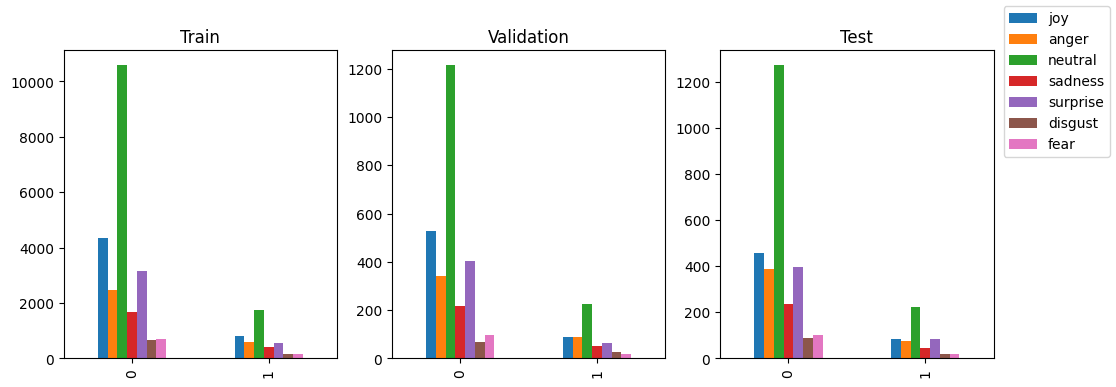

In [22]:
df_manager.plot_emotion_distribution(train_df, val_df, test_df)

In [23]:
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DefaultDataCollator()

KeyboardInterrupt: 

In [ ]:
train_data_tokenized, val_data_tokenized, test_data_tokenized = df_manager.produce_dataset(tokenizer, RANDOM_SEED)

C:\Users\mpsta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
print(len(train_data_tokenized))
print(len(val_data_tokenized))
print(len(test_data_tokenized))

2876
306
315


In [ ]:
train_data_tokenized[0]

{'emotions_id_one_hot_encoding': tensor([0, 0, 0, 1, 0, 0, 0]),
 'emotions_id': tensor(3),
 'triggers': tensor(0),
 'dialogue_ids': tensor([  101,  2298,  1010,  1045,  2514,  2428,  2919,  2055,  2129,  1045,
         22783,  2017,  2041,  2077,  1010,  2061,  1045,  2170,  1996,  2269,
          1998,  2356,  2032,  2000,  3113,  2017,  2182,  2061,  2017,  2064,
          2425,  2032,  1012,   102,  2175,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


Models

In [ ]:
seeds = [666, 55, 42]

X = train_data_tokenized['dialogue_index']
Y = train_data_tokenized.select_columns(['triggers', 'emotions_id'])
seed_table = {'majority': {}, 'uniform': {},
              'model_BERT': {}, 'model_BERT_Freezed': {}}

id2emotion = df_manager.get_id2emotion()
random_clf = Baseline("uniform", X, Y)
majority_clf = Baseline("most_frequent", X, Y)
for seed in seeds:
    seed_table["uniform"][seed] = random_clf.score()
    seed_table["majority"][seed] = majority_clf.score()

In [ ]:
seed_table

{'majority': {666: {'accuracy_emotions': 0.1697,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0389,
   'f1scores_emotions_flatten': 0.0414,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0},
  55: {'accuracy_emotions': 0.1697,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0389,
   'f1scores_emotions_flatten': 0.0414,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0},
  42: {'accuracy_emotions': 0.1697,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0389,
   'f1scores_emotions_flatten': 0.0414,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0}},
 'uniform': {666: {'accuracy_emotions': 0.1453,
   'accuracy_triggers': 0.1446,
   'f1scores_emotions_instance': 0.0504,
   'f1scores_emotions_flatten': 0.0639,
   'f1scores_triggers_instance': 0.1575,
   'f1scores_triggers_flatten': 0.2017},
  55: {'accuracy_emotions': 0.1415,
   'accuracy_triggers': 0.1391,
   'f1sco

In [ ]:
def init_pos_weight(data, labels, class_weights=True, factor=1):
    if class_weights:
        pos_weight = list()
        emotions_counts = {label:0 for label in df_manager.unique_emotions}
        for sentence_emotions in data[df_manager.column_emotions_id]:
            for emotion in sentence_emotions:
                emotions_counts[emotion] = emotions_counts[emotion] + 1
        sum_of_all_emotions = sum(emotions_counts.values())
        for label in labels:
            w = (sum_of_all_emotions-emotions_counts[label])/emotions_counts[label]   # num_neg/num_pos for each class as specified in the documentation for BCEWithLogitsLoss
            if w > 1:                       # increase recall of minority classes
                w*=factor                   # factor to magnify the weight (not standard)
                pos_weight.append(w)
            else:
                pos_weight.append(1)        # non minority classes are not influenced (pos_weight = 1)
        return torch.tensor(pos_weight).to("cuda")
    else:
        return torch.ones([len(labels)]).to("cuda")

In [ ]:
model_B = BERT_Model_Phrase_Concatenation(df_manager)
def try_model_Concatenation(batch_start, batch_end):
        outputs_text = model_B(utterance_ids=train_data_tokenized[batch_start:batch_end]['utterance_ids'],
                utterance_mask=train_data_tokenized[batch_start:batch_end]['utterance_mask'],
                dialogue_ids=train_data_tokenized[batch_start:batch_end]['dialogue_ids'],
                dialogue_mask=train_data_tokenized[batch_start:batch_end]['dialogue_mask'],
                token_type_ids=None)
        return outputs_text
#outputs_text = try_model_Concatenation(0, 30)
#print(outputs_text['emotion_logits'].shape)
#print(outputs_text['trigger_logits'].shape)

In [ ]:
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        self.pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs["emotions_id_one_hot_encoding"].to("cuda")
        triggers_true = inputs["triggers"].float().unsqueeze(1).to("cuda")

        result = model(**inputs)
        
        emotion_logits = result['emotion_logits'].to("cuda")
        trigger_logits = result['trigger_logits'].to("cuda")
        
        loss_fct_emotions = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)        
        loss_fct_triggers = torch.nn.BCEWithLogitsLoss()

        loss_triggers = loss_fct_triggers(trigger_logits, triggers_true)
        loss_emotions = loss_fct_emotions(emotion_logits, emotions_true.float())

        loss = loss_emotions + loss_triggers
        return (loss, {'emotion_logits': emotion_logits, 'trigger_logits': trigger_logits}) if return_outputs else loss

def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-4,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        lr_scheduler_type="cosine_with_restarts",
        save_total_limit = 1,
        load_best_model_at_end=True,
        metric_for_best_model='f1scores_emotions_instance',
        report_to='none',
        label_names=["emotions_id", "triggers", "dialogue_index", "emotions_id_one_hot_encoding"],
    )
    pos_weight = init_pos_weight(concatenate_datasets([train_data_tokenized, val_data_tokenized, test_data_tokenized]), df_manager.emotion2id.keys(), False)
    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_for_trainer,
    )

    return trainer

In [ ]:
seeds = [666]
for seed in seeds:
        set_seeds(seed)
        base_model = BERT_Model_Phrase_Concatenation(df_manager)
        # base_model_freezed = BERT_Model(freeze=True)

        # Create trainer for Conclusion only
        trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_dir+"baseline", class_weights=True, batch_size=1, epochs=10)

        # Create trainer for Conclusion+Premises
        # trainer_freezed = get_trainer(base_model_freezed, train_dataset, val_dataset, model_dir+"baseline_freezed", class_weights=True, batch_size=1, epochs=10)
        print(f'Training BASE_MODEL with seed {seed}:')
        #trainer.evaluate(val_data_tokenized[0])

        trainer.train()

        #print(f'Training BASE_MODEL_FREEZED with seed {seed}:')
        #trainer_freezed.train()

        #test_prediction_info = trainer.predict(dataset)
        #test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
        #test_metrics.append(compute_metrics([test_predictions, test_labels], list(level_2.keys())))
#
        ## fill seed table
        #seed_table["model_BERT"][seed] = test_bert
        #seed_table["model_BERT_Freezed"][seed] = test_CP

C:\Users\mpsta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training BASE_MODEL with seed 666:


  2%|▏         | 501/28760 [01:21<1:20:40,  5.84it/s]

{'loss': 1.4224, 'grad_norm': 0.00030932665686123073, 'learning_rate': 0.00019985088407333137, 'epoch': 0.17}


  3%|▎         | 1001/28760 [02:39<1:11:50,  6.44it/s]

{'loss': 1.4112, 'grad_norm': 0.00014732219278812408, 'learning_rate': 0.0001994039810045172, 'epoch': 0.35}


  5%|▌         | 1501/28760 [03:57<1:12:08,  6.30it/s]

{'loss': 1.4095, 'grad_norm': 9.274970943806693e-05, 'learning_rate': 0.00019866062360086216, 'epoch': 0.52}


  7%|▋         | 2001/28760 [05:15<1:10:55,  6.29it/s]

{'loss': 1.4106, 'grad_norm': 4.892054130323231e-05, 'learning_rate': 0.0001976230287909282, 'epoch': 0.7}


  9%|▊         | 2501/28760 [06:31<1:06:35,  6.57it/s]

{'loss': 1.408, 'grad_norm': 4.845267903874628e-05, 'learning_rate': 0.00019629429101294707, 'epoch': 0.87}


                                                      
 10%|█         | 2876/28760 [07:41<1:06:45,  6.46it/s]

{'eval_loss': 1.4146583080291748, 'eval_accuracy_emotions': 0.4216, 'eval_accuracy_triggers': 0.7876, 'eval_f1scores_emotions_instance': 0.0825, 'eval_f1scores_emotions_flatten': 0.0847, 'eval_f1scores_triggers_instance': 0.4183, 'eval_f1scores_triggers_flatten': 0.4406, 'eval_runtime': 12.4356, 'eval_samples_per_second': 24.607, 'eval_steps_per_second': 24.607, 'epoch': 1.0}


 10%|█         | 3001/28760 [08:02<1:06:00,  6.50it/s] 

{'loss': 1.4095, 'grad_norm': 3.827056571026333e-05, 'learning_rate': 0.00019467837298622003, 'epoch': 1.04}


 12%|█▏        | 3501/28760 [09:18<1:04:03,  6.57it/s]

{'loss': 1.4146, 'grad_norm': 4.0961207560030743e-05, 'learning_rate': 0.0001927800938930266, 'epoch': 1.22}


 14%|█▍        | 4001/28760 [10:33<1:02:13,  6.63it/s]

{'loss': 1.4129, 'grad_norm': 3.214838943677023e-05, 'learning_rate': 0.00019060511500628794, 'epoch': 1.39}


 16%|█▌        | 4501/28760 [11:49<1:01:29,  6.57it/s]

{'loss': 1.4075, 'grad_norm': 1.0839185961231124e-05, 'learning_rate': 0.00018815992280584763, 'epoch': 1.56}


 17%|█▋        | 5001/28760 [13:05<1:00:24,  6.56it/s]

{'loss': 1.406, 'grad_norm': 1.1228910807403736e-05, 'learning_rate': 0.00018545180963372272, 'epoch': 1.74}


 19%|█▉        | 5501/28760 [14:21<59:49,  6.48it/s]  

{'loss': 1.4095, 'grad_norm': 6.741813194821589e-06, 'learning_rate': 0.00018248885194601698, 'epoch': 1.91}


                                                      
 20%|██        | 5752/28760 [15:11<58:09,  6.59it/s]

{'eval_loss': 1.4146581888198853, 'eval_accuracy_emotions': 0.4216, 'eval_accuracy_triggers': 0.7876, 'eval_f1scores_emotions_instance': 0.0825, 'eval_f1scores_emotions_flatten': 0.0847, 'eval_f1scores_triggers_instance': 0.4183, 'eval_f1scores_triggers_flatten': 0.4406, 'eval_runtime': 12.3948, 'eval_samples_per_second': 24.688, 'eval_steps_per_second': 24.688, 'epoch': 2.0}


 21%|██        | 6001/28760 [15:51<57:25,  6.61it/s]   

{'loss': 1.4129, 'grad_norm': 6.30615704722004e-06, 'learning_rate': 0.0001792798862263559, 'epoch': 2.09}


 22%|██▏       | 6389/28760 [46:00<56:57,  6.55it/s]      

KeyboardInterrupt: 